### 1. Importando bibliotecas

In [438]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import batched

### 2. Funções

#### 2.1 Função de treinamento

In [439]:
def treinamento(X_train, y_train, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed):
    """
        Argumentos:
        X_train -- matriz de entrada contendo as amostras de treino
        y_train -- vetor contendo os rótulos desejados para as amostras de treino
        qtd_atributos -- número de (features) presentes nas amostras
        tx_aprendizagem -- taxa de aprendizado, define o passo da atualização dos pesos
        epocas -- número máximo de ciclos completos sobre o conjunto de treinamento
        batch -- se True, o treinamento ocorre por lotes e se None, o treinamento ocorre por amostra
        precisao -- critério de parada baseado na diferença entre EQM de épocas consecutivas
        seed -- semente para inicialização dos pesos aleatórios
        
        Saída:
        parâmetros -- python tuple:
                        pesos -- vetor de pesos ajustados após o treinamento
                        epocas_executadas -- número total de épocas percorridas até a convergência
                        evolucao_erro -- lista com a evolução do erro de classificação ao longo das épocas
    """

    if seed is not None:                            # iniciando o vetor de pesos
        np.random.seed(seed)
        pesos = np.random.uniform(low=-1, high=1, size=((qtd_atributos + 1),))   # vetor de peso (atributos + bias)
    else:
        pesos = np.random.uniform(low=-1, high=1, size=((qtd_atributos + 1),))              # vetor de peso (atributos + bias)

    X = np.c_[np.ones(len(X_train)), X_train]
    y = y_train.flatten()                           # garantindo que é um vetor unidimensional

    evolucao_erro = []
    evolucao_eqm = []
    epoca = 0

    while epoca < epocas:

        if epoca > 0:
            EQM_anterior = erro_quadratico(X, y, pesos)
        else:
            EQM_anterior = 1e6              # tratamento para a primeira epoca
        
        if batch:                           # treinamento por lote (todas as amostras)
            u = np.dot(X, pesos)            # potencial de ativação
            erro = y - u
            pesos += tx_aprendizagem * np.dot(X.T, erro)
        
        else:                               # treinamento por amostra
            for amostra in range(len(X)):
                u = np.dot(pesos, X[amostra])   # potencial de ativação
                erro = y[amostra] - u
                pesos += tx_aprendizagem * erro * X[amostra]
        
        epoca += 1
        
        EQM_atual = erro_quadratico(X, y, pesos)
        evolucao_eqm.append(EQM_atual)
        
        predicoes = np.where(np.dot(X, pesos) >= 0, 1, -1)
        erro = np.count_nonzero(predicoes - y)
        evolucao_erro.append(erro/len(y))

        acuracia = np.mean(predicoes == y)
        
        if np.abs(EQM_atual - EQM_anterior) <= precisao:
            break
    
    return pesos, epoca, evolucao_erro, acuracia, evolucao_eqm

def erro_quadratico(X, y, pesos):
    return np.mean((y - np.dot(X, pesos))**2)

#### 2.2 Função de teste

In [440]:
def teste(X_test, y_test, pesos):
    """
        Argumentos:
        X_test -- amostras de teste
        y_test -- resultados desejados das amostras de teste
        pesos -- vetor de pesos aprendidos durante o treinamento
        
        Saída:
        parâmetros -- python tuple:
                        acuracia -- percentual de acertos do modelo no conjunto de teste
                        predicoes -- vetor contendo as previsões do modelo para X_test
    """


    X_test = np.asarray(X_test)
    X = np.c_[np.ones(len(X_test)), X_test]

    y = np.asarray(y_test).flatten()                # garantindo que é um vetor unidimensional

    predicoes = np.where(np.dot(X, pesos) >= 0, 1, -1)

    acuracia = np.mean(predicoes == y)
    
    return acuracia

### 3. Experimentos

#### 3.1. Carregando os arquivos CSV

In [441]:
# Organizando variáveis e evitando sobrescrita
datasets = {}

def carregar_dataset(nome, train_path, test_path):
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    
    datasets[nome] = {
        "X_train": df_train.drop("label", axis=1).values,
        "y_train": df_train["label"].values.reshape(1, -1).T,
        "X_test": df_test.drop("label", axis=1).values,
        "y_test": df_test["label"].values.reshape(1, -1).T
    }

carregar_dataset("dataset1", "arquivos_csv/train_dataset1.csv", "arquivos_csv/test_dataset1.csv")
carregar_dataset("dataset2", "arquivos_csv/train_dataset2.csv", "arquivos_csv/test_dataset2.csv")
carregar_dataset("dataset3", "arquivos_csv/train_dataset3.csv", "arquivos_csv/test_dataset3.csv")

# ------- Dataset #1 -------
X_train_1 = datasets["dataset1"]["X_train"]
y_train_1 = datasets["dataset1"]["y_train"]
X_test_1 = datasets["dataset1"]["X_test"]
y_test_1 = datasets["dataset1"]["y_test"]

# ------- Dataset #2 -------
X_train_2 = datasets["dataset2"]["X_train"]
y_train_2 = datasets["dataset2"]["y_train"]
X_test_2 = datasets["dataset2"]["X_test"]
y_test_2 = datasets["dataset2"]["y_test"]

# ------- Dataset #3 -------
X_train_3 = datasets["dataset3"]["X_train"]
y_train_3 = datasets["dataset3"]["y_train"]
X_test_3 = datasets["dataset3"]["X_test"]
y_test_3 = datasets["dataset3"]["y_test"]

#### 3.2 Dataset 1

##### 3.2.1 Analisando o dataset

In [442]:
# Tamanho do dataset
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("---------------------")
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape)

X_train_1:  (140, 2)
y_train_1:  (140, 1)
---------------------
X_test_1:  (60, 2)
y_test_1:  (60, 1)


In [443]:
# Razão de treino e teste
print("Razão de treino: ", X_train_1.shape[0]/(X_train_1.shape[0] + X_test_1.shape[0]))
print("Razão de teste: ", X_test_1.shape[0]/(X_train_1.shape[0] + X_test_1.shape[0]))

Razão de treino:  0.7
Razão de teste:  0.3


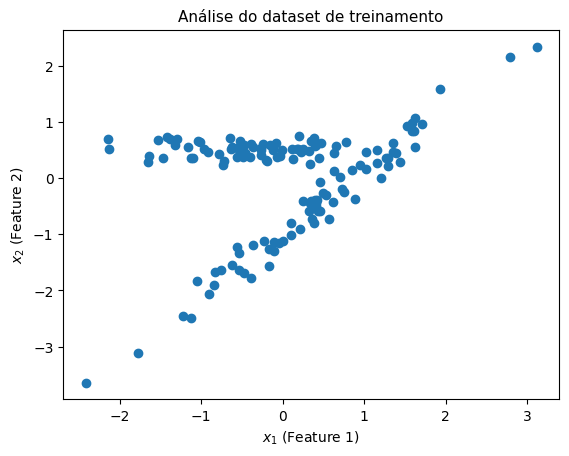

In [444]:
# Plot dos dados de treinamento
X_train_T = X_train_1.T
plt.scatter(X_train_T[0], X_train_T[1])
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Análise do dataset de treinamento", fontsize=11)
plt.show()

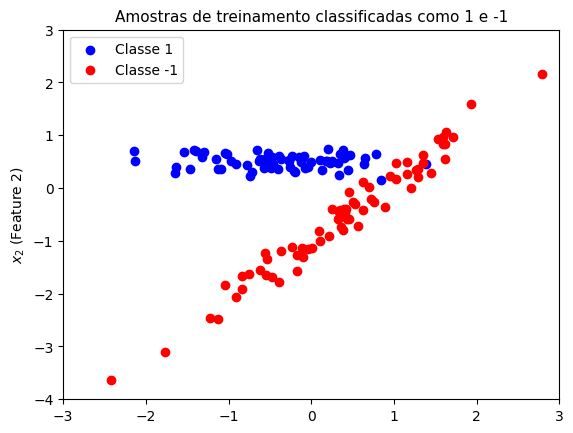

In [445]:
# Plot dos dados de treinamento
df1_treino_classe_1 = X_train_1[y_train_1.flatten() == 1]          # amostras da classe 1
df1_treino_classe_menos_1 = X_train_1[y_train_1.flatten() == -1]     # amostras da classe -1

plt.scatter(df1_treino_classe_1[:, 0], df1_treino_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df1_treino_classe_menos_1[:, 0], df1_treino_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Amostras de treinamento classificadas como 1 e -1", fontsize=11)
plt.xlim(-3, 3)
plt.ylim(-4, 3)
plt.legend()
plt.show()

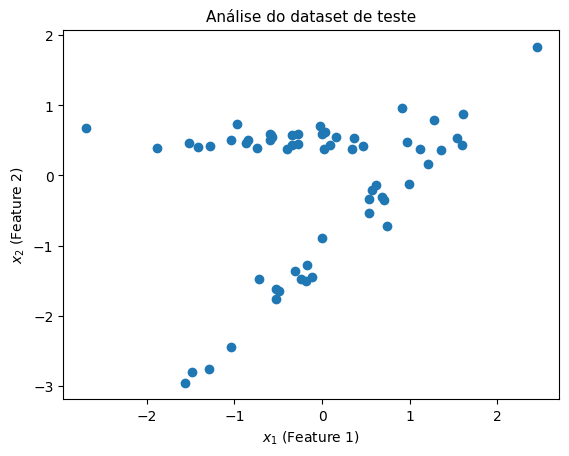

In [446]:
# Plot dos dados de teste
X_test_T = X_test_1.T
plt.scatter(X_test_T[0], X_test_T[1])
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Análise do dataset de teste", fontsize=11)
plt.show()

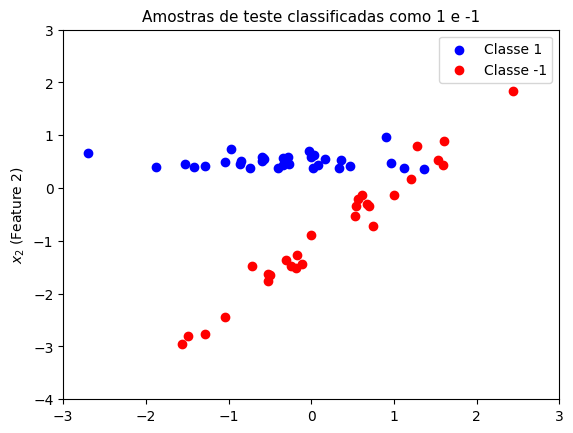

In [447]:
# Plot dos dados de teste
df1_teste_classe_1 = X_test_1[y_test_1.flatten() == 1]          # amostras da classe 1
df1_teste_classe_menos_1 = X_test_1[y_test_1.flatten() == -1]     # amostras da classe -1

plt.scatter(df1_teste_classe_1[:, 0], df1_teste_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df1_teste_classe_menos_1[:, 0], df1_teste_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Amostras de teste classificadas como 1 e -1", fontsize=11)
plt.xlim(-3, 3)
plt.ylim(-4, 3)
plt.legend()
plt.show()

##### 3.2.2 Treinando o ADALINE

###### 3.2.2.a Aprendizado por lote

In [448]:
qtd_atributos = X_train_1.shape[1]
tx_aprendizagem = 0.001
epocas = 100
batch = True
precisao = 0.001
seed = 16

resultado_treino_lote = treinamento(X_train_1, y_train_1, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed)    # return pesos, epoca, evolucao_erro, acuracia
print(f"Acurácia no treino por lote: {resultado_treino_lote[3]:.3%}")

Acurácia no treino por lote: 95.000%


###### 3.2.2.b Aprendizado por amostra

In [449]:
qtd_atributos = X_train_1.shape[1]
tx_aprendizagem = 0.001
epocas = 100
batch = False
precisao = 0.001
seed = 16

resultado_treino_amostra = treinamento(X_train_1, y_train_1, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed)     # return pesos, epoca, evolucao_erro, acuracia
print(f"Acurácia no treino por lote: {resultado_treino_amostra[3]:.3%}")

Acurácia no treino por lote: 95.000%


###### 3.2.2.c Evolução do erro de treinamento e curva de EQM

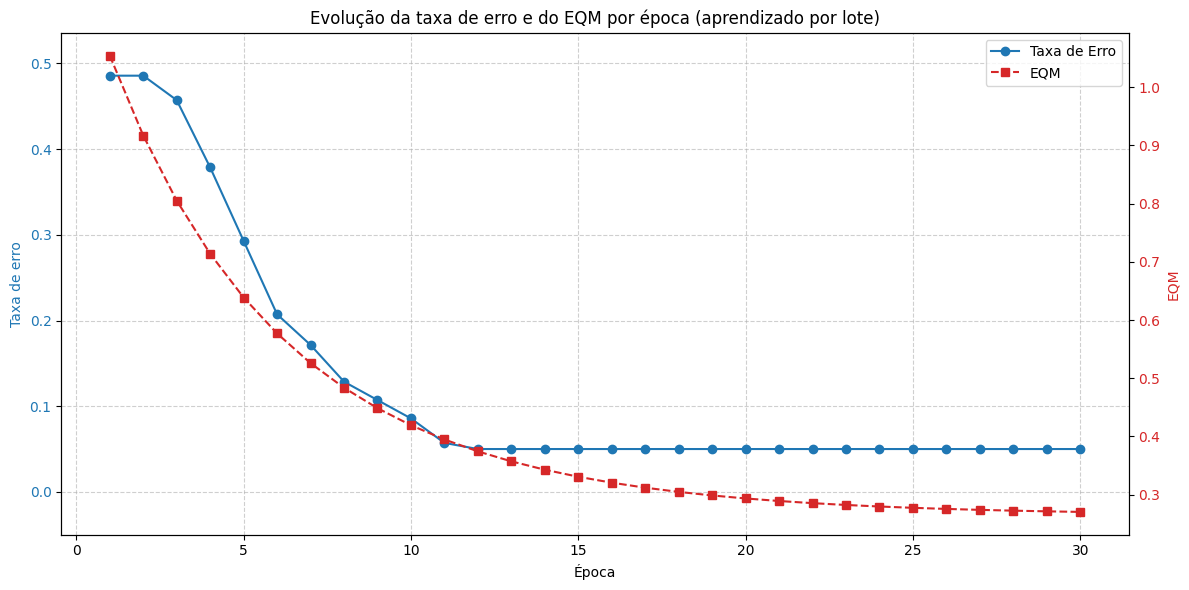

In [450]:
# Aprendizado por lote
x = np.array(range(1, resultado_treino_lote[1] + 1))
taxa_erro = resultado_treino_lote[2]
eqm = resultado_treino_lote[4]

fig, ax1 = plt.subplots(figsize=(12, 6))

cor_erro = 'tab:blue'       # eixo y - evolução do erro
ax1.set_xlabel('Época')
ax1.set_ylabel('Taxa de erro', color=cor_erro)
ax1.plot(x, taxa_erro, 'o-', color=cor_erro, label='Taxa de Erro')
ax1.tick_params(axis='y', labelcolor=cor_erro)
ax1.set_ylim(-0.05, min(1.05, max(taxa_erro)+0.05))

ax2 = ax1.twinx()           # eixo y - curva de EQM
cor_eqm = 'tab:red'
ax2.set_ylabel('EQM', color=cor_eqm)
ax2.plot(x, eqm, 's--', color=cor_eqm, label='EQM')
ax2.tick_params(axis='y', labelcolor=cor_eqm)

plt.title('Evolução da taxa de erro e do EQM por época (aprendizado por lote)')
ax1.grid(True, linestyle='--', alpha=0.6)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.tight_layout()
plt.show()


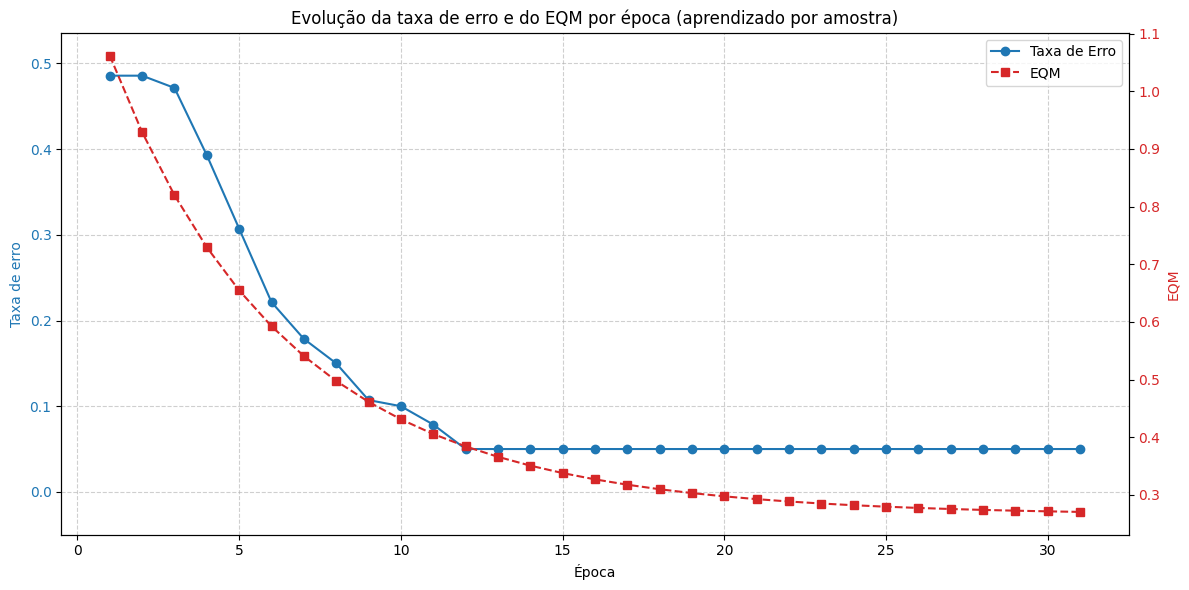

In [451]:
# Aprendizado por amostra
x = np.array(range(1, resultado_treino_amostra[1] + 1))
taxa_erro = resultado_treino_amostra[2]
eqm = resultado_treino_amostra[4]

fig, ax1 = plt.subplots(figsize=(12, 6))

cor_erro = 'tab:blue'       # eixo y - evolução do erro
ax1.set_xlabel('Época')
ax1.set_ylabel('Taxa de erro', color=cor_erro)
ax1.plot(x, taxa_erro, 'o-', color=cor_erro, label='Taxa de Erro')
ax1.tick_params(axis='y', labelcolor=cor_erro)
ax1.set_ylim(-0.05, min(1.05, max(taxa_erro)+0.05))

ax2 = ax1.twinx()           # eixo y - curva de EQM
cor_eqm = 'tab:red'
ax2.set_ylabel('EQM', color=cor_eqm)
ax2.plot(x, eqm, 's--', color=cor_eqm, label='EQM')
ax2.tick_params(axis='y', labelcolor=cor_eqm)

plt.title('Evolução da taxa de erro e do EQM por época (aprendizado por amostra)')
ax1.grid(True, linestyle='--', alpha=0.6)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.tight_layout()
plt.show()

##### 3.2.3 Testando o ADALINE

###### 3.2.3.a Aprendizado por lote

In [452]:
resultado_teste_lote = teste(X_test_1, y_test_1, resultado_treino_lote[0])
print(f"Acurácia do teste (aprendizado por lote): {resultado_teste_lote:.3%}")

Acurácia do teste (aprendizado por lote): 93.333%


###### 3.2.3.b Aprendizado por amostra

In [453]:
resultado_teste_amostra = teste(X_test_1, y_test_1, resultado_treino_amostra[0])
print(f"Acurácia do teste (aprendizado por amostra): {resultado_teste_amostra:.3%}")

Acurácia do teste (aprendizado por amostra): 93.333%


##### 3.2.4 Fronteira de decisão

É a reta que separa as duas classes classificadas pelo ADALINE.

Como temos dois atributos ($x_{1}$ e $x_{2}$), logo o potencial de ativação é dado por $u = x_{1} * w_{1} + x_{2} * w_{2} - \theta$. Asssumindo $x_{1}$ como $x$ e $x_{2}$ como $y$, a equação se parecerá com a equação geral da reta, dada por $A_{x} + B_{y} + C = 0$. Assim, podemos reordenar os termos e isolar $x_{2}$, obtendo $x_{2}$ = $\frac{\theta}{w_{2}} - \frac{w_{1}}{w_{2}}x_{1}$ ou $y$ = $\frac{\theta}{w_{2}} - \frac{w_{1}}{w_{2}}x$.

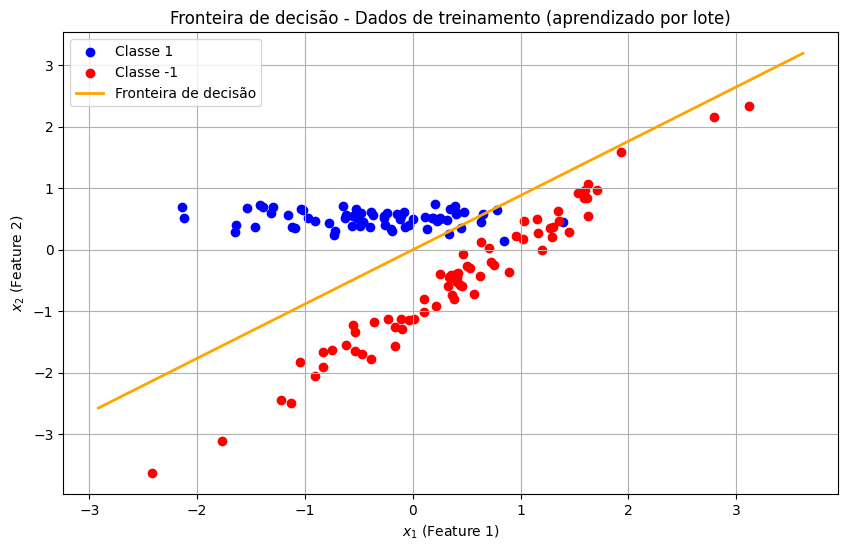

In [454]:
# Fronteira de decisão dos dados de treino (aprendizado por lote)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_lote
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_train_1[:, 0].min(), X_train_1[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df1_treino_classe_1[:, 0], df1_treino_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df1_treino_classe_menos_1[:, 0], df1_treino_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de treinamento (aprendizado por lote)')
plt.legend()
plt.grid(True)
plt.show()

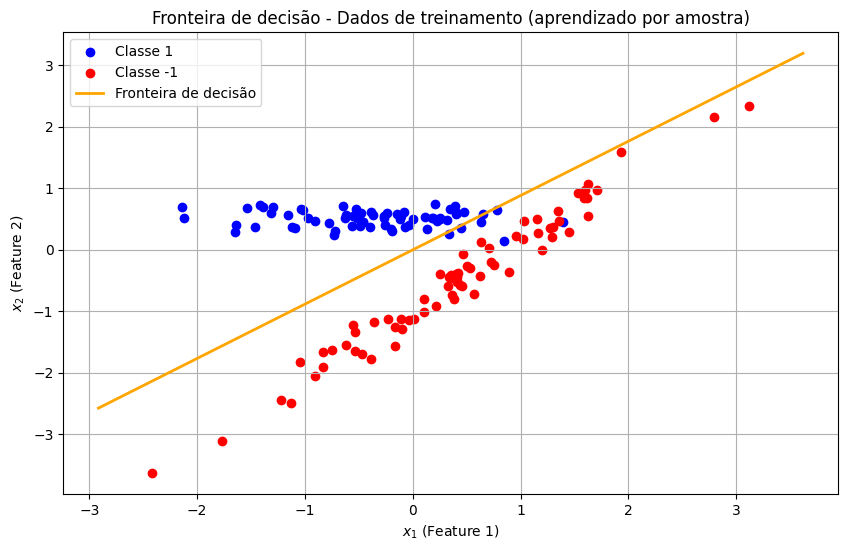

In [455]:
# Fronteira de decisão dos dados de treinamento (aprendizado por amostra)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_amostra
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_train_1[:, 0].min(), X_train_1[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df1_treino_classe_1[:, 0], df1_treino_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df1_treino_classe_menos_1[:, 0], df1_treino_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de treinamento (aprendizado por amostra)')
plt.legend()
plt.grid(True)
plt.show()

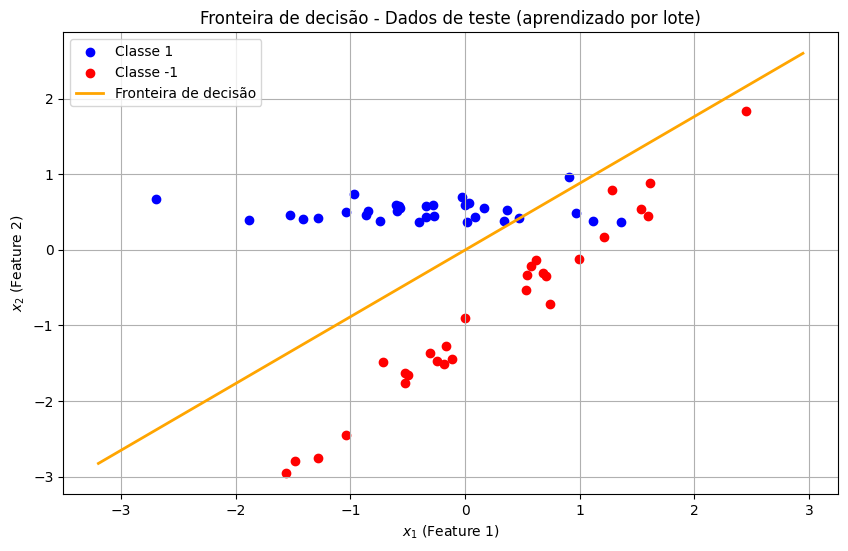

In [456]:
# Fronteira de decisão dos dados de teste (aprendizado por lote)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_lote
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_test_1[:, 0].min(), X_test_1[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df1_teste_classe_1[:, 0], df1_teste_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df1_teste_classe_menos_1[:, 0], df1_teste_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de teste (aprendizado por lote)')
plt.legend()
plt.grid(True)
plt.show()

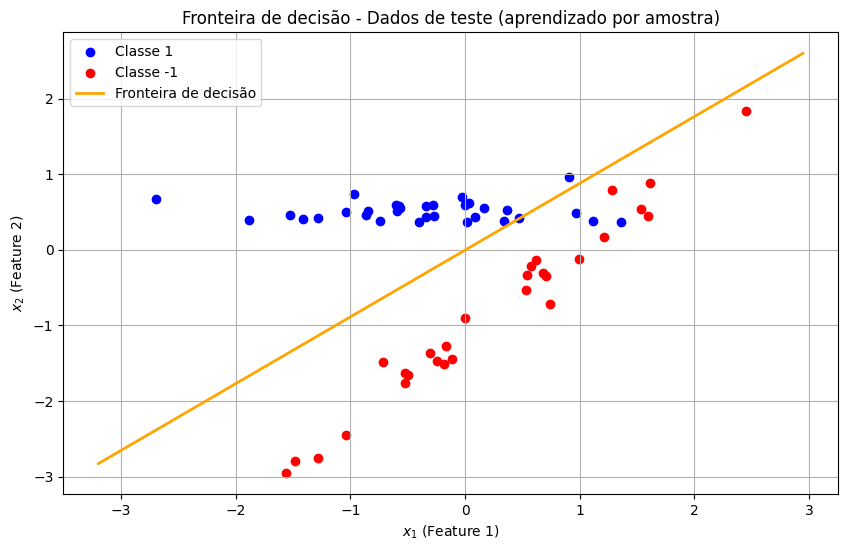

In [457]:
# Fronteira de decisão dos dados de teste (aprendizado por amostra)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_amostra
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_test_1[:, 0].min(), X_test_1[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df1_teste_classe_1[:, 0], df1_teste_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df1_teste_classe_menos_1[:, 0], df1_teste_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de teste (aprendizado por amostra)')
plt.legend()
plt.grid(True)
plt.show()

##### 3.2.5 Resultados observados

- A taxa de aprendizado utilizada apresentou um bom resultado, visto que a convergência aconteceu por volta da época 30 (100 épocas era o máximo);
- A rede convergiu mais rápido no aprendizado por lote (batch), visto que esse aprendizado reduz o ruído estatístico;
- A taxa de erro é mais consistente (poucas variações) que a taxa de erro apresentada na implementação do Single Layer Perceptron no mesmo dataset;
- A acurácia no treinamento por lote e por amostra foi a mesma, visto que os dados são linearmente separáveis e simples de separar;

#### 3.3 Dataset 2

##### 3.3.1 Analisando o dataset

In [458]:
# Tamanho do dataset
print("X_train_2: ", X_train_2.shape)
print("y_train_2: ", y_train_2.shape)
print("---------------------")
print("X_test_2: ", X_test_2.shape)
print("y_test_2: ", y_test_2.shape)

X_train_2:  (175, 2)
y_train_2:  (175, 1)
---------------------
X_test_2:  (75, 2)
y_test_2:  (75, 1)


In [459]:
# Razão de treino e teste
print("Razão de treino: ", X_train_2.shape[0]/(X_train_2.shape[0] + X_test_2.shape[0]))
print("Razão de teste: ", X_test_2.shape[0]/(X_train_2.shape[0] + X_test_2.shape[0]))

Razão de treino:  0.7
Razão de teste:  0.3


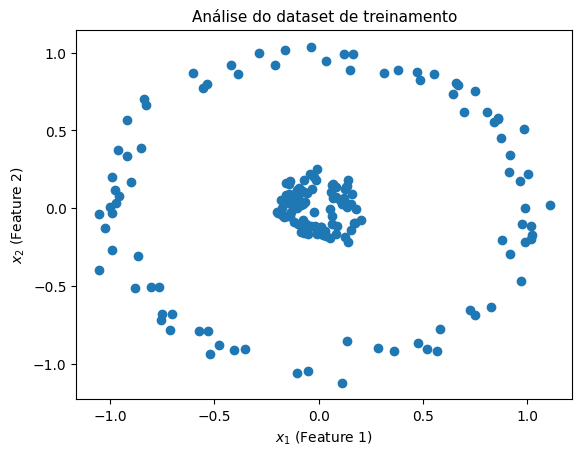

In [460]:
# Plot dos dados de treinamento
X_train_T = X_train_2.T
plt.scatter(X_train_T[0], X_train_T[1])
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Análise do dataset de treinamento", fontsize=11)
plt.show()

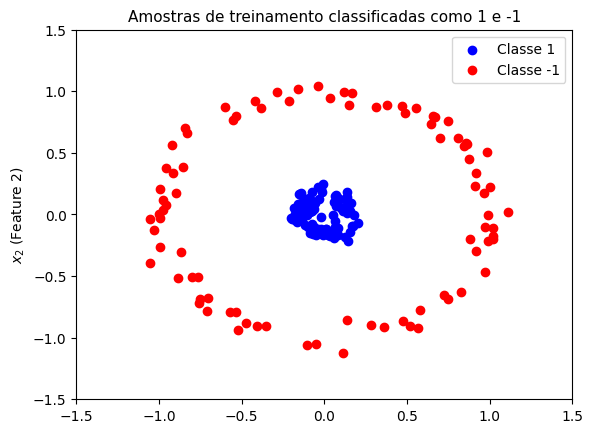

In [461]:
# Plot dos dados de treinamento
df2_treino_classe_1 = X_train_2[y_train_2.flatten() == 1]          # amostras da classe 1
df2_treino_classe_menos_1 = X_train_2[y_train_2.flatten() == -1]     # amostras da classe -1

plt.scatter(df2_treino_classe_1[:, 0], df2_treino_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df2_treino_classe_menos_1[:, 0], df2_treino_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Amostras de treinamento classificadas como 1 e -1", fontsize=11)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

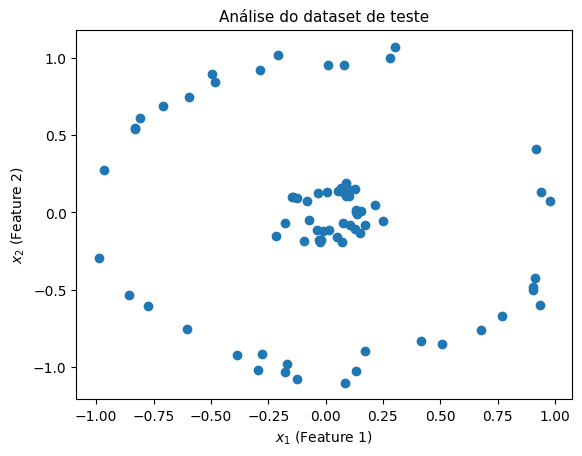

In [462]:
# Plot dos dados de teste
X_test_T = X_test_2.T
plt.scatter(X_test_T[0], X_test_T[1])
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Análise do dataset de teste", fontsize=11)
plt.show()

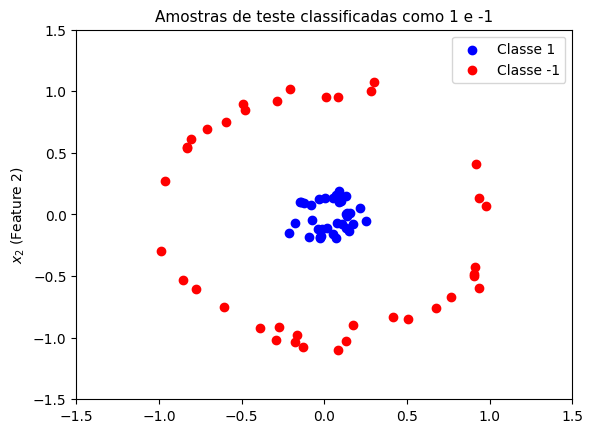

In [463]:
# Plot dos dados de teste
df2_teste_classe_1 = X_test_2[y_test_2.flatten() == 1]          # amostras da classe 1
df2_teste_classe_menos_1 = X_test_2[y_test_2.flatten() == -1]     # amostras da classe -1

plt.scatter(df2_teste_classe_1[:, 0], df2_teste_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df2_teste_classe_menos_1[:, 0], df2_teste_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Amostras de teste classificadas como 1 e -1", fontsize=11)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

##### 3.2.2 Treinando o ADALINE

###### 3.2.2.a Aprendizado por lote

In [464]:
qtd_atributos = X_train_2.shape[1]
tx_aprendizagem = 0.001
epocas = 100
batch = True
precisao = 0.001
seed = 16

resultado_treino_lote = treinamento(X_train_2, y_train_2, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed)    # return pesos, epoca, evolucao_erro, acuracia
print(f"Acurácia no treino por lote: {resultado_treino_lote[3]:.3%}")

Acurácia no treino por lote: 49.714%


###### 3.2.2.b Aprendizado por amostra

In [465]:
qtd_atributos = X_train_2.shape[1]
tx_aprendizagem = 0.001
epocas = 100
batch = False
precisao = 0.001
seed = 16

resultado_treino_amostra = treinamento(X_train_2, y_train_2, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed)     # return pesos, epoca, evolucao_erro, acuracia
print(f"Acurácia no treino por lote: {resultado_treino_amostra[3]:.3%}")

Acurácia no treino por lote: 49.714%


###### 3.2.2.c Evolução do erro de treinamento e curva de EQM

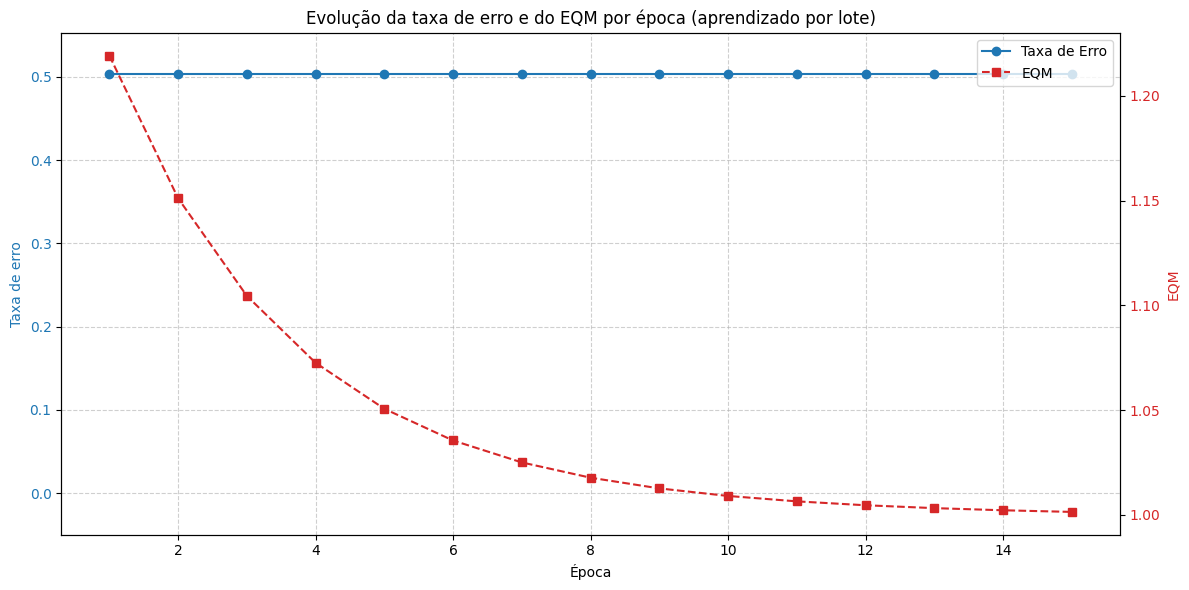

In [466]:
# Aprendizado por lote
x = np.array(range(1, resultado_treino_lote[1] + 1))
taxa_erro = resultado_treino_lote[2]
eqm = resultado_treino_lote[4]

fig, ax1 = plt.subplots(figsize=(12, 6))

cor_erro = 'tab:blue'       # eixo y - evolução do erro
ax1.set_xlabel('Época')
ax1.set_ylabel('Taxa de erro', color=cor_erro)
ax1.plot(x, taxa_erro, 'o-', color=cor_erro, label='Taxa de Erro')
ax1.tick_params(axis='y', labelcolor=cor_erro)
ax1.set_ylim(-0.05, min(1.05, max(taxa_erro)+0.05))

ax2 = ax1.twinx()           # eixo y - curva de EQM
cor_eqm = 'tab:red'
ax2.set_ylabel('EQM', color=cor_eqm)
ax2.plot(x, eqm, 's--', color=cor_eqm, label='EQM')
ax2.tick_params(axis='y', labelcolor=cor_eqm)

plt.title('Evolução da taxa de erro e do EQM por época (aprendizado por lote)')
ax1.grid(True, linestyle='--', alpha=0.6)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.tight_layout()
plt.show()


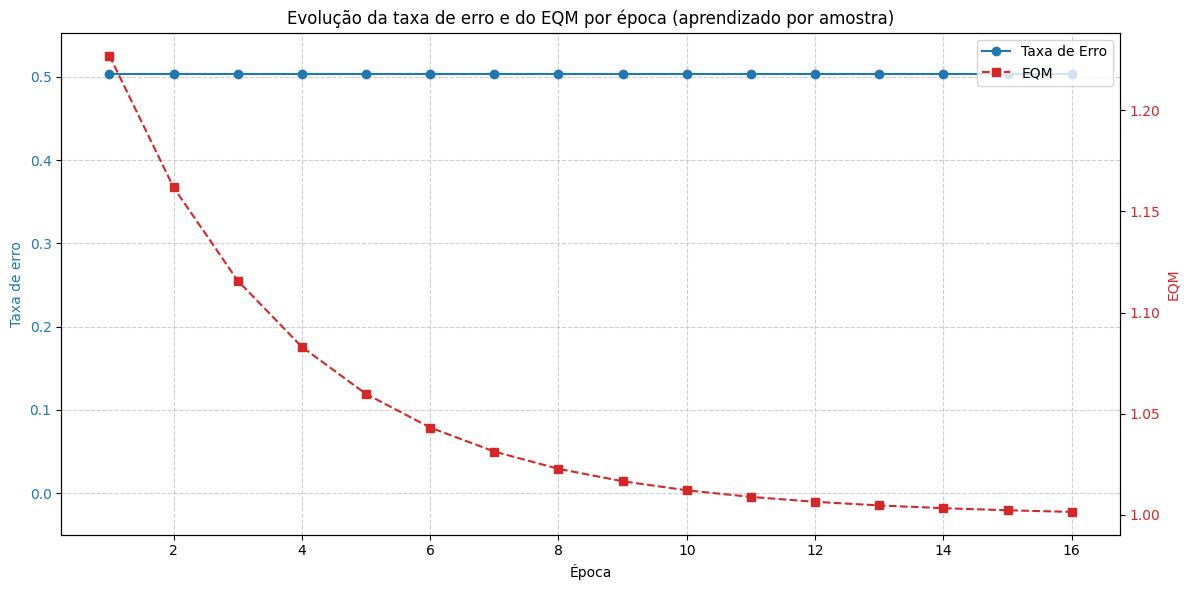

In [467]:
# Aprendizado por amostra
x = np.array(range(1, resultado_treino_amostra[1] + 1))
taxa_erro = resultado_treino_amostra[2]
eqm = resultado_treino_amostra[4]

fig, ax1 = plt.subplots(figsize=(12, 6))

cor_erro = 'tab:blue'       # eixo y - evolução do erro
ax1.set_xlabel('Época')
ax1.set_ylabel('Taxa de erro', color=cor_erro)
ax1.plot(x, taxa_erro, 'o-', color=cor_erro, label='Taxa de Erro')
ax1.tick_params(axis='y', labelcolor=cor_erro)
ax1.set_ylim(-0.05, min(1.05, max(taxa_erro)+0.05))

ax2 = ax1.twinx()           # eixo y - curva de EQM
cor_eqm = 'tab:red'
ax2.set_ylabel('EQM', color=cor_eqm)
ax2.plot(x, eqm, 's--', color=cor_eqm, label='EQM')
ax2.tick_params(axis='y', labelcolor=cor_eqm)

plt.title('Evolução da taxa de erro e do EQM por época (aprendizado por amostra)')
ax1.grid(True, linestyle='--', alpha=0.6)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.tight_layout()
plt.show()

##### 3.2.3 Testando o ADALINE

###### 3.2.3.a Aprendizado por lote

In [468]:
resultado_teste_lote = teste(X_test_2, y_test_2, resultado_treino_lote[0])
print(f"Acurácia do teste (aprendizado por lote): {resultado_teste_lote:.3%}")

Acurácia do teste (aprendizado por lote): 50.667%


###### 3.2.3.b Aprendizado por amostra

In [469]:
resultado_teste_amostra = teste(X_test_2, y_test_2, resultado_treino_amostra[0])
print(f"Acurácia do teste (aprendizado por amostra): {resultado_teste_amostra:.3%}")

Acurácia do teste (aprendizado por amostra): 50.667%


##### 3.2.4 Fronteira de decisão

É a reta que separa as duas classes classificadas pelo ADALINE.

Como temos dois atributos ($x_{1}$ e $x_{2}$), logo o potencial de ativação é dado por $u = x_{1} * w_{1} + x_{2} * w_{2} - \theta$. Asssumindo $x_{1}$ como $x$ e $x_{2}$ como $y$, a equação se parecerá com a equação geral da reta, dada por $A_{x} + B_{y} + C = 0$. Assim, podemos reordenar os termos e isolar $x_{2}$, obtendo $x_{2}$ = $\frac{\theta}{w_{2}} - \frac{w_{1}}{w_{2}}x_{1}$ ou $y$ = $\frac{\theta}{w_{2}} - \frac{w_{1}}{w_{2}}x$.

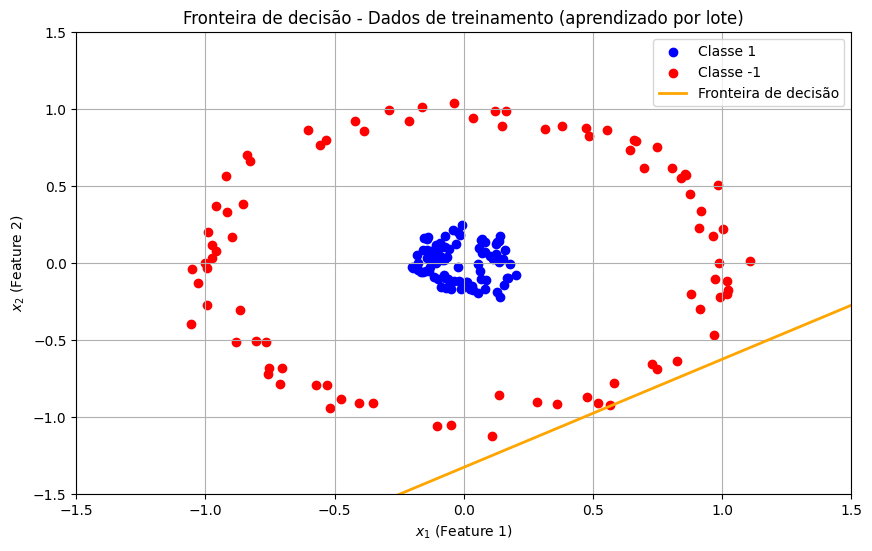

In [470]:
# Fronteira de decisão dos dados de treino (aprendizado por lote)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_lote
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_train_2[:, 0].min(), X_train_2[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df2_treino_classe_1[:, 0], df2_treino_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df2_treino_classe_menos_1[:, 0], df2_treino_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de treinamento (aprendizado por lote)')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

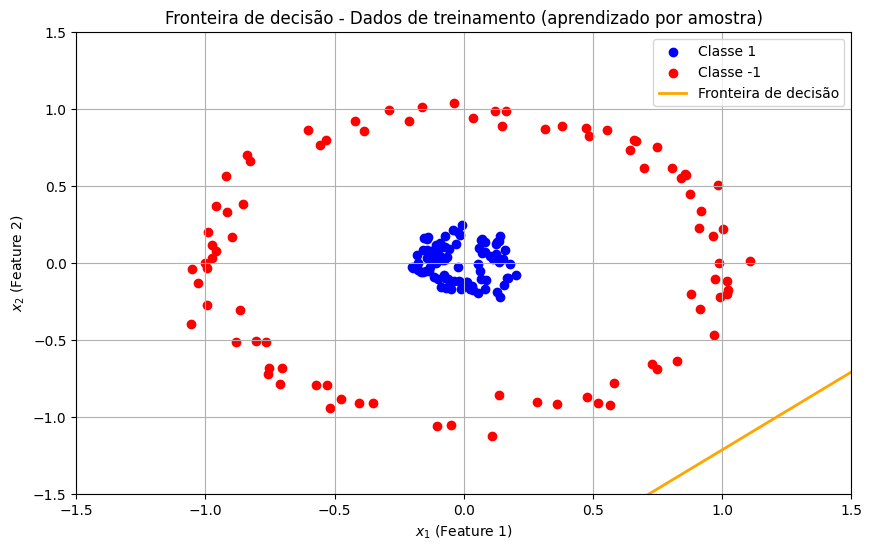

In [471]:
# Fronteira de decisão dos dados de treinamento (aprendizado por amostra)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_amostra
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_train_2[:, 0].min(), X_train_2[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df2_treino_classe_1[:, 0], df2_treino_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df2_treino_classe_menos_1[:, 0], df2_treino_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de treinamento (aprendizado por amostra)')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

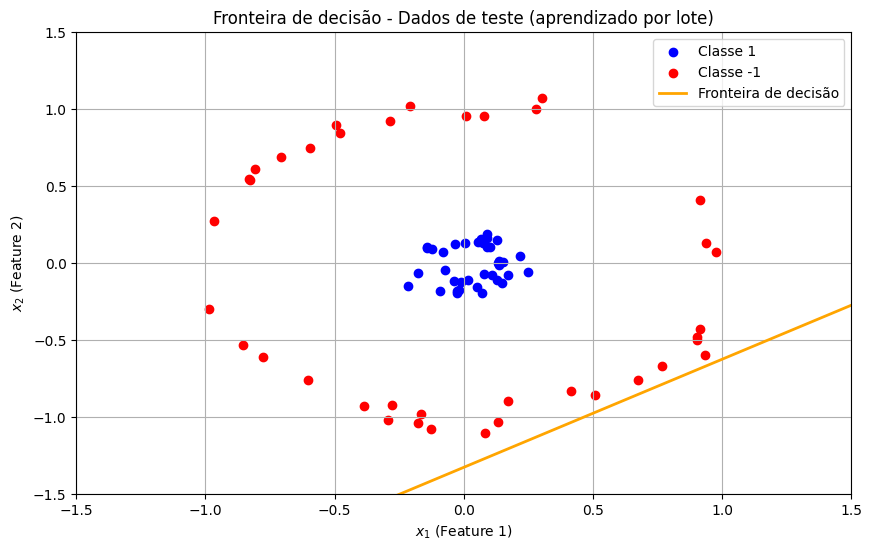

In [472]:
# Fronteira de decisão dos dados de teste (aprendizado por lote)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_lote
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_test_1[:, 0].min(), X_test_1[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df2_teste_classe_1[:, 0], df2_teste_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df2_teste_classe_menos_1[:, 0], df2_teste_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de teste (aprendizado por lote)')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

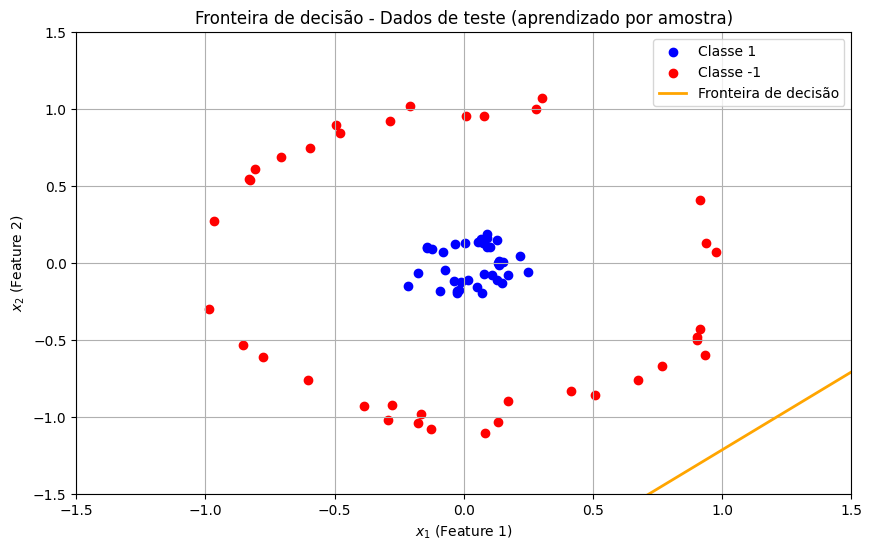

In [473]:
# Fronteira de decisão dos dados de teste (aprendizado por amostra)
pesos_lote, epoca, erro, acuracia, evolucao_eqm = resultado_treino_amostra
bias, w1, w2 = pesos_lote

x1_min, x1_max = X_test_1[:, 0].min(), X_test_1[:, 0].max()   # pega os pontos de mínimo e máximo
x1 = np.linspace(x1_min - 0.5, x1_max + 0.5, 100)               # pega 100 pontos dentro do mínimo e máximo
x2 = ((-x1 * w1) + bias) / w2                                   # equação da fronteira de decisão

plt.figure(figsize=(10, 6))
plt.scatter(df2_teste_classe_1[:, 0], df2_teste_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df2_teste_classe_menos_1[:, 0], df2_teste_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.plot(x1, x2, 'orange', linewidth=2, label='Fronteira de decisão')
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title('Fronteira de decisão - Dados de teste (aprendizado por amostra)')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

##### 3.2.5 Resultados observados

- A curva de EQM apresenta queda, porém a diferença de 0.2 ao longo das épocas é pequena, ou seja, a convergência foi lenta;
- Essa convergência se deu pelo fato dos dados não serem linearmente separáveis, o que explica a acurácia como um "chute";
- Não é possível atingir melhores resultados, visto que o modelo aplicado é um separador linear;

### Referências

- Slides de aula apresentados pelo docente;
- https://github.com/lucasanches/single-layer-perceptron;
- https://medium.com/data-scientists-diary/online-vs-batch-learning-in-machine-learning-385d21511ec3;
